# RQ3: Do the all trips last the same?  (EDA)
Now we are going to analyze the distribution of the duration of the trip. To do this, at the beginning we calculate the trip duration based on data from 2018. Next, we will look at the data and on this basis we will perform filtration and cleaning. Next, we will launch the analysis for NYC and for each borough, while visualizing the results accordingly.

We import Python libraries and functions defined in another file that we will need for our analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import RQ3_functions
import warnings; warnings.simplefilter('ignore')

In the analysis, we used the following data columns:
* **tpep_pickup_datetime** - The date and time when the meter was engaged.
* **tpep_dropoff_datetime** -  The date and time when the meter was disengaged. 
* **PULocationID** -  TLC Taxi Zone in which the taximeter was engaged
* **DOLocationID** -  TLC Taxi Zone in which the taximeter was disengaged


We calculated the duration of all taxi journeys each month, which is the time between column "tpep_pickup_datetime" and column "tpep_dropoff_datetime". 

The function **get_trip_duration_all_months** returns a data frame with interested columns and an additional column that contains the calculated values in minutes.

In [7]:
# trip_duration_all_months_df = pd.read_csv("D:/trip_duration_all_months_df.csv")

In [3]:
trip_duration_all_months_df = RQ3_functions.get_trip_duration_all_months(path = "D:/")

Information about boroughs is obtained from the CSV table : taxi_zone_lookup.csv

In [4]:
taxi_zone_lookup = pd.read_csv("taxi_zone_lookup.csv")
print("The unique boroughs are: {}".format(taxi_zone_lookup["Borough"].unique()))

The unique boroughs are: ['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn' 'Unknown']


After preliminary analysis we see that there are six boroughs, which corresponds to the LocationID column. It has also been noticed that the data contains "Unknown" locations.

------------

### Data filtration and cleaning 


We check the most common statistics about the **duration** column:

In [8]:
trip_duration_all_months_df.duration.describe(percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

count    5.392574e+07
mean     1.604486e+01
std      1.455252e+03
min     -1.066961e+07
50%      1.000000e+01
60%      1.300000e+01
70%      1.600000e+01
80%      2.000000e+01
90%      2.700000e+01
95%      3.600000e+01
99%      6.100000e+01
max      8.852000e+03
Name: duration, dtype: float64

* We observe that **the minimum value is less than 0 minutes**. It is in reality impossible (probably there was a mistake). Thus, it is reasonable to ignore values less than 0 minutes as well as equal to 0. 
* What about the upper range? We noticed that **the maximum value is much higher than 99th percentile**. For the further analysis we wanna ignore the outliers. 
--------------
To decide where to set the upper limit for data on trip length, we check for a few selected values their percentiles.

In [9]:
print("Trip duration less than...")
for score in range(70, 130, 10):
    print("{0} mins -> {1:.3f} percentile".format(score, stats.percentileofscore(trip_duration_all_months_df.duration, score)))

Trip duration less than...
70 mins -> 99.393 percentile
80 mins -> 99.610 percentile
90 mins -> 99.713 percentile
100 mins -> 99.757 percentile
110 mins -> 99.775 percentile
120 mins -> 99.783 percentile


* It seems rational to conduct analysis for **trips under 100 minutes**, that represent a significant amount of data.

Subsequently, on the basis of the above analyzes and assumptions, we filter the data on the duration of the trip.

In [10]:
filtered_trip_duration_df = trip_duration_all_months_df[trip_duration_all_months_df.duration.between(0, 100, inclusive=False)]

### Visualization for the NYC

We plot **the density histogram** for the duration column. 
Additionally, we draw two vertical lines, which are **the mean line - in black** and **the mode line - in blue** .

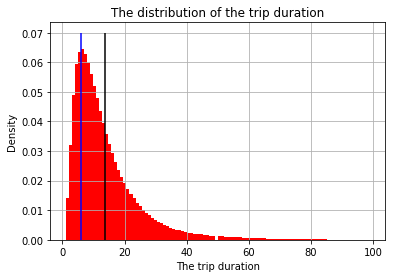

In [18]:
RQ3_functions.plot_distribution_trip_duration(filtered_trip_duration_df)

* It is **a right-skewed distribution**, in which the data tends to gradually taper off to a right long tail. This means that for long-lasting journeys, the longer the time, the less likely they are to occur.
* Outliers were filtered out previously. The data is from range (0, 100) minutes.
* **Mean = 13.6**. On average, the taxi trip duration is about 14 minutes.
* **Standard deviation = 11.3**
* **The mode = 6**. It means that the trips which lasts 6 minutes are very common. It seems to be reasonable.  

-------------
### Analysis and visualization for each borough

This analysis is based on __PULocationID__ - the location in which the taximeter was engaged.

At first, we merge the data frame with the trip duration with the taxi_lookup_file in order to get information about each borough. Then, we group by a borough and calculate some statistics like the mean and number of records. Finally, we visualise the distributions for each borough using seaborn library.

In [33]:
# Basic statistics for each borough
grouped_trip_duration_borough = RQ3_functions.merge_and_group_by(filtered_trip_duration_df).agg({'mean', 'count'})
grouped_trip_duration_borough

duration           
                  count       mean
Borough                           
Bronx             51387  18.410512
Brooklyn         667319  14.791699
EWR                 657  11.800609
Manhattan      48570759  12.297417
Queens          3247019  32.442868
Staten Island       513  25.436647
Unknown          793977  13.244881

Plotting the density histograms with fitted lines for each borough. 

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


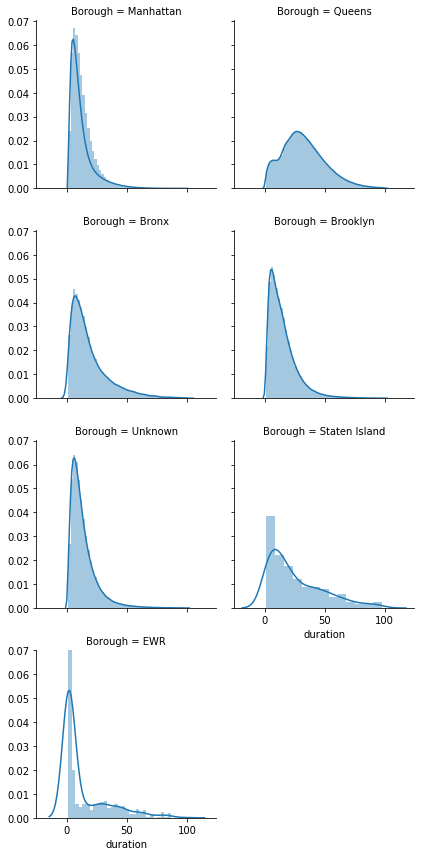

In [112]:
g = sns.FacetGrid(trip_duration_borough, col='Borough', col_wrap=2)
g = g.map(sns.distplot, "duration", kde=True)

It is obvious that **all trips do not last the same**. Distributions of their duration are different for each borough.
However, the brounghs: Bronx, MAnhattan and Brooklyn seems to be quite similar. They are right-skewed, as well. 
The borough EWR seems to be interesting, because there is a lot of very short-time trips. This borough has the smallest average length of taxi travel about 12 minutes.
The distribution for the Queens is more flattened. There are usually more medium-lasting trips. The average length of the trip is about 30 minutes.
